In [9]:
import os
import numpy as np
import pandas as pd
#時間
from datetime import date
#前處理
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder
#模型
from sklearn.linear_model import SGDClassifier,LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error,r2_score

import matplotlib.pyplot as plt


In [10]:
DATA_ROOT = "./pm/"
print(os.listdir("./pm"))

['2014.csv', '2015.csv', '2016.csv', 'd2017.csv', 'd2018.csv', 'Demo_test.csv', 'pm.csv', 'pm2014.csv', 'pm2015.csv', 'pm2016.csv', 'pm2017.csv', 'pm2018.csv', 'pmall.csv', 'pmmergeclean.csv', 'pmtest.csv', 'pmtest1.csv', 'pm_train.csv', 'test.csv', '空氣品質監測小時值.csv', '空氣品質監測小時值xxx.csv', '離群值.PNG', '離群值2.PNG']


In [11]:
data = pd.read_csv(os.path.join(DATA_ROOT,'pmall.csv'), encoding='big5')
data = data.drop([0])
data = data.drop(['序號','縣市','鄉鎮市區','測站'],axis = 1)
feature1 = ['NOx','WIND_DIREC','O3','PM2.5','NMHC','CO','NO','NO2','RH','PM10','CH4','WIND_SPEED','AMB_TEMP','THC','WS_HR','WD_HR','SO2']

In [12]:
data.head(3)

,監測日期,測項(單位),小時測值,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,...,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29
1,2018/6/30,氮氧化物 NOx (ppb),5.4,4.3,3.3,2.9,2.3,5.3,13,18.0,...,2.8,2.9,2.4,3.1,16,17,16,15.0,15,17
2,2018/6/30,風向 WIND_DIREC (degrees),258,258,265.0,248.0,258.0,97.0,52,204.0,...,247,277,283,51,106,36,123,110.0,27,295
3,2018/6/30,臭氧 O3 (ppb),9.7,14,16.0,16.0,19.0,13.0,6.1,10.0,...,33,33,30,34,22,19,18,18.0,19,16


In [13]:
##每17筆資料一組，重新轉置後合併在一起
#總計112組
data2 = pd.DataFrame()
for i in range(1,113):
    data_date = pd.DataFrame({'DATE' : [data.loc[17*i,'監測日期']]*24})#生成日期
    data_hour = pd.DataFrame({'Hour' : list(range(0, 24))})#生成時間
    data_temp = data.iloc[17*i-17:17*i,2:]#每次取17特徵
    data_temp = data_temp.T#轉置
    data_temp.columns = feature1   
    data_temp = data_temp.reset_index(drop = True)
    data_temp = pd.concat([data_temp,data_date],axis=1)
    data_temp = pd.concat([data_temp,data_hour],axis=1)
    data2 =  pd.concat([data2,data_temp], axis=0,sort =False)
    
data2 = data2.reset_index(drop = True)
data2.head(3)

,NOx,WIND_DIREC,O3,PM2.5,NMHC,CO,NO,NO2,RH,PM10,CH4,WIND_SPEED,AMB_TEMP,THC,WS_HR,WD_HR,SO2,DATE,Hour
0,5.4,258,9.7,4,0.01,0.1,0.7,4.7,77,16,1.7,1.7,29,1.7,1.2,253,1.5,2018/6/30,0
1,4.3,258,14,9,0,0.09,0.2,4.1,77,14,1.7,1.4,29,1.7,1.3,256,1,2018/6/30,1
2,3.3,265,16,6,0,0.09,-0.1,3.4,80,17,1.7,0.8,29,1.7,1.2,256,0.6,2018/6/30,2


In [14]:
#調整順序
data2 = data2[['NOx','WIND_DIREC','O3','NMHC','CO','NO','NO2','RH','PM10','CH4','WIND_SPEED','AMB_TEMP','THC','WS_HR','WD_HR','SO2','DATE','Hour','PM2.5']]
#針對這些特徵從物件轉成浮點數型態
feature2 =['NOx','WIND_DIREC','O3','NMHC','CO','NO','NO2','RH','PM10','CH4','WIND_SPEED','AMB_TEMP','THC','WS_HR','WD_HR','SO2']
for i in feature2:
    data2[i] = data2[i].astype('float64')
data2.to_csv('pmmerge.csv', index=False)
print(data2['PM2.5'].dtype)
data2.head(3)


object


,NOx,WIND_DIREC,O3,NMHC,CO,NO,NO2,RH,PM10,CH4,WIND_SPEED,AMB_TEMP,THC,WS_HR,WD_HR,SO2,DATE,Hour,PM2.5
0,5.4,258.0,9.7,0.01,0.10,0.7,4.7,77.0,16.0,1.7,1.7,29.0,1.7,1.2,253.0,1.5,2018/6/30,0,4
1,4.3,258.0,14.0,0.00,0.09,0.2,4.1,77.0,14.0,1.7,1.4,29.0,1.7,1.3,256.0,1.0,2018/6/30,1,9
2,3.3,265.0,16.0,0.00,0.09,-0.1,3.4,80.0,17.0,1.7,0.8,29.0,1.7,1.2,256.0,0.6,2018/6/30,2,6


In [15]:
'''測試資料處理'''
#pmtest1
datatest = pd.read_csv(os.path.join(DATA_ROOT,'pmtest1.csv'), encoding='big5')
datatest = datatest.drop([0])
datatest = datatest.drop(['序號','縣市','鄉鎮市區','測站'],axis = 1)
datatest.head(3)

,監測日期,測項(單位),小時測值,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,...,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29
1,2019/6/3,氮氧化物 NOx (ppb),6.5,14.0,13.0,12.0,12.0,25.0,36.0,15.0,...,2.5,3.2,3.8,5.8,4.5,6.4,5.4,7.0,7.4,5.6
2,2019/6/3,二氧化硫 SO2 (ppb),2.0,2.4,3.1,2.6,2.6,3.7,4.7,3.3,...,1.5,1.7,1.7,1.6,2.0,2.1,1.9,1.9,2.3,1.8
3,2019/6/3,臭氧 O3 (ppb),9.7,4.6,4.2,4.9,3.5,2.5,4.8,18.0,...,23.0,22.0,23.0,21.0,22.0,19.0,20.0,16.0,16.0,15.0


In [16]:
'''
data2test = pd.DataFrame()
for i in range(1,3):
    datatest_date = pd.DataFrame({'DATE' : [datatest.loc[17*i,'監測日期']]*24})#生成日期
    datatest_hour = pd.DataFrame({'Hour' : list(range(0, 24))})#生成時間
    datatest_temp = datatest.iloc[17*i-17:17*i,2:]#每次取17特徵
    datatest_index = datatest.loc[17*i-17:17*i,'測項(單位)']
    datatest_temp.index = datatest_index
    datatest_temp = datatest_temp.T#轉置
    
    datatest_temp.columns = feature1   
    datatest_temp = datatest_temp.reset_index(drop = True)
    datatest_temp = pd.concat([datatest_temp,datatest_date],axis=1)
    datatest_temp = pd.concat([datatest_temp,datatest_hour],axis=1)
    data2test =  pd.concat([data2test,datatest_temp], axis=0,sort =False)
'''

"\ndata2test = pd.DataFrame()\nfor i in range(1,3):\n    datatest_date = pd.DataFrame({'DATE' : [datatest.loc[17*i,'監測日期']]*24})#生成日期\n    datatest_hour = pd.DataFrame({'Hour' : list(range(0, 24))})#生成時間\n    datatest_temp = datatest.iloc[17*i-17:17*i,2:]#每次取17特徵\n    datatest_index = datatest.loc[17*i-17:17*i,'測項(單位)']\n    datatest_temp.index = datatest_index\n    datatest_temp = datatest_temp.T#轉置\n    \n    datatest_temp.columns = feature1   \n    datatest_temp = datatest_temp.reset_index(drop = True)\n    datatest_temp = pd.concat([datatest_temp,datatest_date],axis=1)\n    datatest_temp = pd.concat([datatest_temp,datatest_hour],axis=1)\n    data2test =  pd.concat([data2test,datatest_temp], axis=0,sort =False)\n"

In [17]:
'''測試資料處理'''
data2test = pd.DataFrame()
for i in range(1,4):
    datatest_date = pd.DataFrame({'DATE' : [datatest.loc[17*i,'監測日期']]*24})#生成日期
    datatest_hour = pd.DataFrame({'Hour' : list(range(0, 24))})#生成時間
    datatest_temp = datatest.iloc[17*i-17:17*i,2:]#每次取17特徵
    datatest_temp = datatest_temp.T#轉置
    datatest_temp.columns = feature1   
    datatest_temp = datatest_temp.reset_index(drop = True)
    datatest_temp = pd.concat([datatest_temp,datatest_date],axis=1)
    datatest_temp = pd.concat([datatest_temp,datatest_hour],axis=1)
    data2test =  pd.concat([data2test,datatest_temp], axis=0,sort =False)
#重新排index跟conlums    
data2test = data2test.reset_index(drop = True)
data2test = data2test[['NOx','WIND_DIREC','O3','NMHC','CO','NO','NO2','RH','PM10','CH4','WIND_SPEED','AMB_TEMP','THC','WS_HR','WD_HR','SO2','DATE','Hour','PM2.5']]

data2test.head(3)

,NOx,WIND_DIREC,O3,NMHC,CO,NO,NO2,RH,PM10,CH4,WIND_SPEED,AMB_TEMP,THC,WS_HR,WD_HR,SO2,DATE,Hour,PM2.5
0,6.5,2.0,9.7,0.05,0.15,0.6,5.9,82.0,11.0,1.7,1.0,29.2,1.8,0.7,18.0,45.0,2019/6/3,0,15.0
1,14.0,2.4,4.6,0.13,0.26,1.1,12.0,83.0,17.0,1.8,0.5,29.1,1.9,0.6,0.8,359.0,2019/6/3,1,8.0
2,13.0,3.1,4.2,0.15,0.23,1.1,12.0,84.0,13.0,1.8,0.5,28.8,2.0,0.4,349.0,282.0,2019/6/3,2,8.0


In [18]:
#data2test.to_csv('datatest.csv', index=False)

In [19]:
#此處先手動清理PM2.5中有異常文字型態的資料及空缺值
dataclean = pd.read_csv(os.path.join(DATA_ROOT,'pmmergeclean.csv'), encoding='big5')
print(dataclean['PM2.5'].dtype)
dataclean.head(3)
#daraclean_label = dataclean['PM2.5']
#dataclean = dataclean.drop(['PM2.5'],axis = 1)
daidx,col = dataclean.shape
print(daidx,col)
dataclean.head(3)


int64
2587 19


,NOx,WIND_DIREC,O3,NMHC,CO,NO,NO2,RH,PM10,CH4,WIND_SPEED,AMB_TEMP,THC,WS_HR,WD_HR,SO2,DATE,Hour,PM2.5
0,5.4,258.0,9.7,0.01,0.10,0.7,4.7,77.0,16.0,1.7,1.7,29.0,1.7,1.2,253.0,1.5,2018/6/30,0,4
1,4.3,258.0,14.0,0.00,0.09,0.2,4.1,77.0,14.0,1.7,1.4,29.0,1.7,1.3,256.0,1.0,2018/6/30,1,9
2,3.3,265.0,16.0,0.00,0.09,-0.1,3.4,80.0,17.0,1.7,0.8,29.0,1.7,1.2,256.0,0.6,2018/6/30,2,6


In [20]:
#是否有缺失資料
#dataclean.isnull().any()

In [21]:
#是否有缺失資料
#data2test.isnull().any()

In [22]:
print(f'dataclean shape = {dataclean.shape}')
print(f'data2test shape = {data2test.shape}')


dataclean shape = (2587, 19)
data2test shape = (72, 19)


In [23]:
'''合併前處理'''
dataclean =  pd.concat([dataclean,data2test], axis=0,sort =False)
dataclean =dataclean.reset_index(drop = True)
print(f'combined dataclean shape = {dataclean.shape}')
dataclean.tail(3)
#traintest合併
dataclean_label = dataclean['PM2.5']
dataclean = dataclean.drop(['PM2.5'],axis = 1)
print(f'dataclean_label shape = {dataclean_label.shape}')

combined dataclean shape = (2659, 19)
dataclean_label shape = (2659,)


In [24]:
'''時間前處理'''
import datetime
dataclean['DATE'] = dataclean['DATE'].apply(lambda x: datetime.datetime.strptime(x, '%Y/%m/%d'))
dataclean['YEAR'] = dataclean['DATE'].apply(lambda x: datetime.datetime.strftime(x, '%Y')).astype('int64')#or object
dataclean['MONTH'] = dataclean['DATE'].apply(lambda x: datetime.datetime.strftime(x, '%m')).astype('int64')#or object
dataclean['DAY'] = dataclean['DATE'].apply(lambda x: datetime.datetime.strftime(x, '%d')).astype('object')# use object
dataclean = dataclean.drop(['DATE'],axis = 1)
dataclean.head(3)

,NOx,WIND_DIREC,O3,NMHC,CO,NO,NO2,RH,PM10,CH4,WIND_SPEED,AMB_TEMP,THC,WS_HR,WD_HR,SO2,Hour,YEAR,MONTH,DAY
0,5.4,258.0,9.7,0.01,0.10,0.7,4.7,77.0,16.0,1.7,1.7,29.0,1.7,1.2,253.0,1.5,0,2018,6,30
1,4.3,258.0,14.0,0.00,0.09,0.2,4.1,77.0,14.0,1.7,1.4,29.0,1.7,1.3,256.0,1.0,1,2018,6,30
2,3.3,265.0,16.0,0.00,0.09,-0.1,3.4,80.0,17.0,1.7,0.8,29.0,1.7,1.2,256.0,0.6,2,2018,6,30


In [25]:
#dataclean.dtypes

In [26]:
#了解是否有空缺值
#dataclean.isnull().any()

In [27]:
'''資料前處理'''
for dtype,feature in zip(dataclean.dtypes,dataclean.columns):
    
    if dtype == 'float64' or dtype =='int64':
        #處理負值與空值
        negidx = dataclean.loc[:][feature]<0
        dataclean.loc[negidx,feature]  = (dataclean[feature].mode()[0]+dataclean[feature].describe()['mean'])/2 #以眾數與平均值的平均取代      
        #處理空缺值
        dataclean[feature].fillna((dataclean[feature].mode()[0]+dataclean[feature].describe()['mean'])/2, inplace=True)
#年月不重要
dataclean = dataclean.drop(['YEAR','MONTH'],axis = 1)

In [28]:
#了解是否有空缺值
#dataclean.isnull().any()

In [29]:
#dataclean.head(3)

In [30]:
'''對日期做one hot'''
feature3 = list(dataclean.columns)
feature3.pop(-1)#消除'DAY，預作one hot
#feature3

'DAY'

In [31]:
#day's type is object
#one hot in day
dataclean = pd.get_dummies(dataclean)
dataclean.head(3)

,NOx,WIND_DIREC,O3,NMHC,CO,NO,NO2,RH,PM10,CH4,...,DAY_21,DAY_22,DAY_23,DAY_24,DAY_25,DAY_26,DAY_27,DAY_28,DAY_29,DAY_30
0,5.4,258.0,9.7,0.01,0.10,0.700000,4.7,77.0,16.0,1.7,...,0,0,0,0,0,0,0,0,0,1
1,4.3,258.0,14.0,0.00,0.09,0.200000,4.1,77.0,14.0,1.7,...,0,0,0,0,0,0,0,0,0,1
2,3.3,265.0,16.0,0.00,0.09,1.917907,3.4,80.0,17.0,1.7,...,0,0,0,0,0,0,0,0,0,1


In [32]:
#特徵處理
MMEncoder = MinMaxScaler()
OHEncoder = OneHotEncoder()
SDEncoder =StandardScaler()  
for c in feature3:
    if dataclean[c].dtype == 'int64' or dataclean[c].dtype=='float64' :
        dataclean[c] = MMEncoder.fit_transform(dataclean[c].values.reshape(-1, 1))
dataclean.head(3)        

,NOx,WIND_DIREC,O3,NMHC,CO,NO,NO2,RH,PM10,CH4,...,DAY_21,DAY_22,DAY_23,DAY_24,DAY_25,DAY_26,DAY_27,DAY_28,DAY_29,DAY_30
0,0.015249,0.716194,0.095144,0.000306,0.009434,0.010937,0.101781,0.777598,0.140271,0.048666,...,0,0,0,0,0,0,0,0,0,1
1,0.011522,0.716194,0.137760,0.000000,0.007075,0.003125,0.086514,0.777598,0.122172,0.048666,...,0,0,0,0,0,0,0,0,0,1
2,0.008133,0.735671,0.157582,0.000000,0.007075,0.029967,0.068702,0.807926,0.149321,0.048666,...,0,0,0,0,0,0,0,0,0,1


In [33]:
#dataclean.isnull().any()

In [34]:
#dataclean_label.isnull().any()

In [35]:
print(dataclean.shape)

(2659, 47)


In [36]:

x_train = dataclean[:2000]
y_train = dataclean_label[:2000]
x_test = dataclean[2000:daidx]
y_test = dataclean_label[2000:daidx]

In [37]:
'''原始分割'''#分割
'''
#x_train,x_test,y_train,y_test = train_test_split(dataclean,daraclean_label,test_size = 0.2,random_state = 87)
print(dataclean.shape)
x_train = dataclean[:daidx]
y_train = dataclean_label[:daidx]
x_test = dataclean[daidx:]
y_test = dataclean_label[daidx:]
x_train
'''

'\n#x_train,x_test,y_train,y_test = train_test_split(dataclean,daraclean_label,test_size = 0.2,random_state = 87)\nprint(dataclean.shape)\nx_train = dataclean[:daidx]\ny_train = dataclean_label[:daidx]\nx_test = dataclean[daidx:]\ny_test = dataclean_label[daidx:]\nx_train\n'

In [38]:
'''線性回歸'''
LR =LinearRegression()
LR.fit(x_train,y_train)
print(f'5折驗證 = {cross_val_score(LR,x_train,y_train,cv= 5).mean()}')
y_pred = LR.predict(x_test)
print(f"Mean squared error: {mean_squared_error(y_test,y_pred)}")

5折驗證 = 0.22908363929407383
Mean squared error: 27.534756681576777


<function matplotlib.pyplot.show(*args, **kw)>

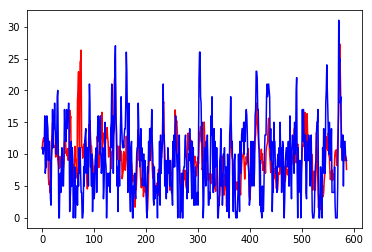

In [39]:
y_test1 = y_test.reset_index(drop = True)
plt.plot(y_pred,'r')
plt.plot(y_test1,'b')
plt.show

In [40]:
'''隨機森林樹回歸'''
regr = RandomForestRegressor()
regr.fit(x_train,y_train)
print(f'5折驗證 = {cross_val_score(regr,x_train,y_train,cv= 5).mean()}')
y_predregr = regr.predict(x_test)
print(f"Mean squared error: {mean_squared_error(y_test,y_predregr)}")

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


5折驗證 = 0.20178707615627728
Mean squared error: 27.31894378194208


<function matplotlib.pyplot.show(*args, **kw)>

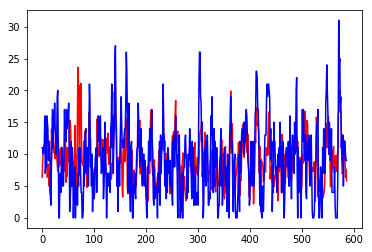

In [41]:
y_test1 = y_test.reset_index(drop = True)
plt.plot(y_predregr,'r')
plt.plot(y_test1,'b')
plt.show